# Molecular property prediction

Now that we know how molecules are stored and how to work with them we can introduce scikit-fingerprints - a library for efficient computation of molecular fingerprints - algorithms for vectorization of molecular graphs.

Install dependencies if necessary (uncomment and run):

In [1]:
# !pip install -r requirements.txt

---

## 1. Molecular property prediction dataset

We will work on BACE dataset from [moleculenet benchmark](https://moleculenet.org/)

The the task of BACE dataset is classifying inhibitors of Beta-Secretase 1 - a protein enzyme playing a significant role in development of Alzheimer’s disease.

For more information read: [Govindan Subramanian et al. “Computational Modeling of β-Secretase 1 (BACE-1) Inhibitors Using Ligand Based Approaches” J. Chem. Inf. Model. 2016, 56, 10, 1936–1949](https://pubs.acs.org/doi/10.1021/acs.jcim.6b00290)

### dataset loader

scikit-fingerprints has its own loaders for several popular datasets.

In [2]:
from skfp.datasets.moleculenet import load_bace

bace_dataset = load_bace()

X_smiles, y = bace_dataset

print(f"Example molecule : {X_smiles[0]}")
print(f"Example class    : {y[0]}")

Example molecule : O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C
Example class    : 1


---

## 2. Preprocessing Molecules

### Convert SMILES to molecules

As you already know we have to convert the SMILES strings to molecule objects. scikit-fingerprints allows us to do that with help of scikit-learn compatible `MolFromSmiles` class.

In [3]:
from skfp.preprocessing import MolFromSmilesTransformer

mol_from_smiles = MolFromSmilesTransformer()

X = mol_from_smiles.transform(X_smiles)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterMatcherBase> already registered; second conversion method ignored.


### Scaffold Split

In molecular property prediction we can NOT use random data split for training and testing datasets.

In the real-world problem of drug design, a trained ML model has to perform well on newly designed molecules that often differ significantly from the ones in the training dataset.

We can group the molecules by the similarity of their internal structure called scaffold, effectively splitting the data into sets that differ from one another.

It's important to note that there are different variants of scaffold split and some benchmarks, such as those provided by Open Graph Benchmark ([OGB](https://ogb.stanford.edu/)), require the user to use a specific, pre-computed train/valid/test index.

In [4]:
from skfp.model_selection import scaffold_train_test_split
import numpy as np

# get split indices
bace_splits = scaffold_train_test_split(
    bace_dataset[0], train_size=0.8, test_size=0.2, return_indices=True
)

train_idx, test_idx = bace_splits

In [5]:
# Split lists of SMILES strings
X_train = np.array(X)[train_idx]
X_test = np.array(X)[test_idx]

# Split labels
y_train = y[train_idx]
y_test = y[test_idx]

In [6]:
print(f"train set size : {X_train.shape[0]}")
print(f"test set size  : {X_test.shape[0]}")

train set size : 1210
test set size  : 303


For the sake of this presentation we can display an exmaple molecule and its scaffold.

In [7]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem
from rdkit import Chem

PATT = Chem.MolFromSmarts("[$([D1]=[*])]")
REPL = Chem.MolFromSmarts("[*]")


# Function for generating scaffold
def get_scaffold(mol):
    Chem.RemoveStereochemistry(mol)
    scaff = MurckoScaffold.GetScaffoldForMol(mol)
    scaff = AllChem.ReplaceSubstructs(scaff, PATT, REPL, replaceAll=True)[0]
    scaff = MurckoScaffold.MakeScaffoldGeneric(scaff)
    scaff = MurckoScaffold.GetScaffoldForMol(scaff)
    return scaff

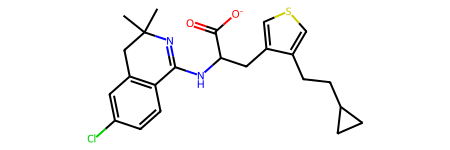

In [8]:
X_train[0]

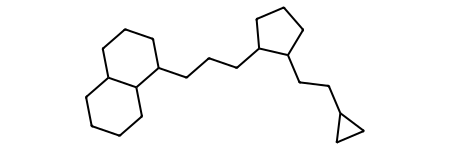

In [9]:
get_scaffold(X_train[0])

---

### Standardize

Molecular standardizer allows us to perform basic sanitization of the molecule object.

In [10]:
from skfp.preprocessing import MolStandardizer

standardizer = MolStandardizer()

X_train_ = standardizer.transform(X_train)
X_test_ = standardizer.transform(X_test)

---

## 3. Single Output Molecular Property Prediction with 2D Fingerprints

To perform a training task on molecules we cannot use the molecule objects as data input.

The molecules are permutation-invariant so there's no simple way of writing them as input vectors.

Fortunately there algorithms that encode molecules into feature vectors. We call them molecular fingerprints and scikit-fingerprints provides a great way of using them in machine learning pipelines.

### Extended Connectivity Fingerprint (ECFP)

We can encode molecules using ECFP fingerprint.

In [11]:
from skfp.fingerprints import ECFPFingerprint

# Creat scikit-learn compatible transformer object
ecfp_fp = ECFPFingerprint(n_jobs=-1, count=True)

# Transform molecules into feature vectors
X_train_ecfp = ecfp_fp.transform(X_train)
X_test_ecfp = ecfp_fp.transform(X_test)

We can check that our molecules have been transformed to vectors.

In [12]:
print(f"data shape     : {X_train_ecfp.shape}")
print(f"example vector : {X_train_ecfp[0]}")

data shape     : (1210, 2048)
example vector : [0 1 0 ... 0 0 0]


### Model training

Then we can perform training using standard scikit-learn models such as Random Forest Classifier.

We use multioutput_auroc_score metric provided by scikit-fingerprints even thought it's a single output task. This way, in case you want to play around with different datasets at home, you can use the same code.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from skfp.metrics import multioutput_auroc_score

# Create random forest classifier object
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

# Fit the train dataset
clf.fit(X_train_ecfp, y_train)

# create a prediction
y_pred = clf.predict_proba(X_test_ecfp)[:, 1]

print(
    f"ECFP AUROC for Random Forest : {100*multioutput_auroc_score(y_test, y_pred):.2f}%"
)

ECFP AUROC for Random Forest : 78.02%


### KNN model training

We can also different models, such as k-nearest-neighbours.

Note that to use nearest neighbours models you will need to use Tanimoto distance.

The formula for calculating Tanimoto distance for binary vector is as follows:

$$
\text{dist}(\vec{a}, \vec{b}) = 1 - \frac{|\vec{a} \cap \vec{b}|}{|\vec{a}| + |\vec{b}| - |\vec{a} \cap \vec{b}|}
$$

A count variant of the distance for non-binary vectors can be defined too:

$$
\text{dist}(\vec{a}, \vec{b}) = 1 - \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\|^2 + \|\vec{b}\|^2 - \vec{a} \cdot \vec{b}}
$$

You can find more information about scikit-fingerprints implementation of Tanimoto distance in [scikit-fingerprints documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from skfp.distances import tanimoto_count_distance

# Our fingerprint used count=True parameter. Because of that we need to use Tanimoto count distance
clf = KNeighborsClassifier(n_jobs=-1, metric=tanimoto_count_distance)

# fit the model
clf.fit(X_train_ecfp, y_train)

y_pred = clf.predict_proba(X_test_ecfp)[:, 1]

print(f"ECFP AUROC for KNN : {100*multioutput_auroc_score(y_test, y_pred):.2f}%")

ECFP AUROC for KNN : 77.04%


### MACCS Keys Fingerprint

ECFP is not the only fingerprint implemented by scikit-fingerprints. There are over 30 different algorithms. For the sake of this tutorial we want to show you one more fingerprint - MACCS Keys Fingerprint.

You can find the information about this fingerprint and how to use it in [scikit-fingerprints documentation](https://scikit-fingerprints.github.io/scikit-fingerprints/) after navigating to the `fingerprints` section.

In [15]:
# import MACCS fingerprint
from skfp.fingerprints import MACCSFingerprint

# Create MACCS transformer object
maccs_fp = MACCSFingerprint(n_jobs=-1, count=True)

# transform the molecules into vectors
X_train_maccs = maccs_fp.transform(X_train)
X_test_maccs = maccs_fp.transform(X_test)

Train random forest model like before.

In [16]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

clf.fit(X_train_maccs, y_train)

y_pred = clf.predict_proba(X_test_maccs)[:, 1]

print(
    f"MACCS AUROC for Random Forest : {100*multioutput_auroc_score(y_test, y_pred):.2f}%"
)

MACCS AUROC for Random Forest : 77.00%


---

## 4. Hyperparameter tuning

Molecular fingerprints have many hyperparameters that can be tuned. To make that easier, scikit-fingerprints implements functionalities that make that task easy.

### Regular scikit-learn based model tuning

First we have to prepare a standard scikit-learn parameter grid and cv estimator object.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Create Random Forest Classifier
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

# Create hyperparameter grid for the classifier
clf_param_grid = {"n_estimators": [200, 500, 1000]}

# create scorer - use multioutput auroc score
scorer = make_scorer(multioutput_auroc_score, greater_is_better=True)

# create grid search object
gridsearch_cv = GridSearchCV(
    estimator=clf,
    param_grid=clf_param_grid,
    scoring=scorer,
    verbose=2,
    cv=5,
    n_jobs=-1,
)

### scikit-fingerprints grid search estimator

Then we wrap it in another cv estimator, this time implemented by scikit-fingerprints. 

It will allow us to avoid unnecessary multiple computation of fingerprint algorithm.

In [18]:
from skfp.model_selection import FingerprintEstimatorGridSearch

# Create fingerprint transformer object
ecfp_fp = ECFPFingerprint(n_jobs=-1)

# fingerprint hyperparameter grid
fp_grid = {
    "fp_size": [1024, 2048, 4096],
    "radius": [2, 3],
    "include_chirality": [False, True],
    "count": [False, True],
}

# Cross-Validation estimator
fp_estimator_cv = FingerprintEstimatorGridSearch(
    fingerprint=ecfp_fp,
    fp_param_grid=fp_grid,
    estimator_cv=gridsearch_cv,
    greater_is_better=True,
)

### Running the training - tuning hyperparameters

Fit the data. We don't need to transform it as the fingerprint object is stored inside the cv estimator class.

In [19]:
from time import time

start = time()
fp_estimator_cv.fit(X_train, y_train)
end = time()
print(f"tuning time : {round(end-start,2)}s")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates


Display the best fingerprint hyperparameters.

In [20]:
print(fp_estimator_cv.best_fp_params_)

{'count': False, 'fp_size': 2048, 'include_chirality': True, 'radius': 2}


Display the best model hyperparameters.

In [21]:
print(fp_estimator_cv.best_estimator_cv_.best_params_)

{'n_estimators': 500}


Check the score.

In [22]:
y_pred = fp_estimator_cv.predict_proba(X_test)[:, 1]

print(f"ECFP AUROC : {100*multioutput_auroc_score(y_test, y_pred):.2f}%")

ECFP AUROC : 78.78%


---

## 5. Multioutput prediction

Some molecular datasets focus on multiple tasks or for different reasons, have multiple label values. Both for regression and classification tasks. scikit-fingerprints eneables the scientists to work easily with this kind of multi-output data.



### Sider dataset

One of such multi-output datasets is SIDER dataset.

The task presented by SIDER dataset is to predict adverse drug reactions (ADRs) as drug side effects to 27 system organ classes in [MedDRA classification](https://pubs.acs.org/doi/10.1021/acscentsci.6b00367)

In [23]:
from skfp.datasets.moleculenet import load_sider

# load SIDER dataset
sider_dataset = load_sider()

# Extract SMILES strings and labels
X_smiles, y = sider_dataset

print(f"Example molecule  : {X_smiles[0]}")
print(f"Example class     : {y[0]}")
print(f"Number of outputs : {y[0].shape[0]}")

Example molecule  : C(CNCCNCCNCCN)N
Example class     : [1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0]
Number of outputs : 27


We can see that there are 27 tasks



### preprocessing

Then we have to perform preprocessing as described before.

Convert smiles to molecules.

In [24]:
mol_from_smiles = MolFromSmilesTransformer()

X = mol_from_smiles.transform(X_smiles)

[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors


Split the dataset.

In [25]:
sider_splits = scaffold_train_test_split(
    sider_dataset[0], train_size=0.8, test_size=0.2, return_indices=True
)

train_idx, test_idx = sider_splits

[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors
[15:30:23] WARNING: not removing hydrogen atom without neighbors


In [26]:
# Split lists of SMILES strings
X_train = np.array(X)[train_idx]
X_test = np.array(X)[test_idx]

# Split labels
y_train = y[train_idx]
y_test = y[test_idx]

Standardize molecules.

In [27]:
standardizer = MolStandardizer()

X_train = standardizer.transform(X_train)
X_test = standardizer.transform(X_test)

### Compute molecular fingerprints

In [28]:
ecfp_fp = ECFPFingerprint(n_jobs=-1, count=True)

X_train_ecfp = ecfp_fp.transform(X_train)
X_test_ecfp = ecfp_fp.transform(X_test)

### Create and train a model

In [29]:
rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=0)

rf_classifier.fit(X_train_ecfp, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

Assert the model performance using mutioutput AUROC score.

In [30]:
from skfp.metrics import extract_multioutput_pos_proba

y_pred = extract_multioutput_pos_proba(rf_classifier.predict_proba(X_test_ecfp))

print(f"Multioutput AUROC : {100*multioutput_auroc_score(y_test, y_pred):.2f}%")

Multioutput AUROC : 63.55%


---

## 6. Pipeline, and comparison with graph neural networks

In [31]:
from skfp.datasets.moleculenet import load_bace
from skfp.model_selection import scaffold_train_valid_test_split

load_bace = load_bace()

X_smiles, y = load_bace

# We want to compare our model to a reference trained on dataset split into a train/valid/test set
bace_splits = scaffold_train_valid_test_split(
    bace_dataset[0], train_size=0.8, valid_size=0.1, test_size=0.1, return_indices=True
)

train_idx, valid_idx, test_idx = bace_splits

X_smiles_train = np.array(X_smiles)[train_idx]
X_smiles_test = np.array(X_smiles)[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

In [32]:
from sklearn.preprocessing import MinMaxScaler
from skfp.fingerprints import TopologicalTorsionFingerprint
from sklearn.pipeline import Pipeline, FeatureUnion

ttfp = TopologicalTorsionFingerprint(
    torsion_atom_count=6,
    n_jobs=-1,
    count=True,
    fp_size=4096,
)

ecfp = ECFPFingerprint(
    radius=2,
    n_jobs=-1,
    count=True,
    fp_size=4096,
)

fingerprint_union = FeatureUnion([("topological_torsion", ttfp), ("ecfp", ecfp)])

random_forest = RandomForestClassifier(
    n_jobs=-1, random_state=0, class_weight="balanced"
)


clf = Pipeline(
    [
        ("mol_from_smiles", MolFromSmilesTransformer()),
        ("mol_sandardizer", MolStandardizer()),
        ("fp_union", fingerprint_union),
        ("scaler", MinMaxScaler()),
        ("random_forest", random_forest),
    ]
)

clf.fit(X_smiles_train, y_train)

y_pred = clf.predict_proba(X_smiles_test)[:, 1]
auroc = multioutput_auroc_score(y_test, y_pred)

print(f"Feature union AUROC for Random Forest: {100*auroc:.2f}%")

Feature union AUROC for Random Forest: 88.50%


In a paper called [Strategies for Pre-training Graph Neural Networks](https://arxiv.org/abs/1905.12265) the best AUROC score for BACE dataset was 84.5%. We managed to outperform a comlpex pretrained GNN using molecular fingerprint algorithms without need of long and heavy training.

Additionally we've made an improvement in comparison to our first training with ECFP fingerprint with Random Forest model that achieved 78.02% AUROC.


## Bonus exercise

TODO